<a href="https://colab.research.google.com/github/thisiseshan/style-transfer-tut/blob/master/Style_Transfer_Tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Style Transfer tutorial with Deep Neural Networks

We will use a VGG19 model to go about this notebook in PyTorch.  Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.

We will first separate our image into two sections:


1.   Content image
2.   Style image

Basic idea is to extract objects and structures from the **Content image** and extract style and colors from **Style image**.


In this notebook, we'll use a pre-trained VGG19 Net to extract content and style features from a image. 
We'll then formalize the idea of content and style losses and use those to iteratively update our target image until we get a result that we want.


Enough talk, Let's get started!


## Imports

In [0]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

##Load pre-trained VGG19 model

In [2]:
# Load features of VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 53.3MB/s]


In [3]:
# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

##Load in Content and Style Images

The `load_image`function here, converts images into normalized tensors

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # Prefer small images as large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

##Load images

In [6]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/images/
  inflating: data/images/sotomayor.jpg  
   creating: __MACOSX/data/images/
  inflating: __MACOSX/data/images/._sotomayor.jpg  
  inflating: data/images/delaunay.jpg  
  inflating: __MACOSX/data/images/._delaunay.jpg  
  inflating: data/images/octopus.jpg  
  inflating: __MACOSX/data/images/._octopus.jpg  
  inflating: data/images/hockney.jpg  
  inflating: __MACOSX/data/images/._hockney.jpg  
  inflating: data/images/magritte.jpg  
  inflating: __MACOSX/data/images/._magritte.jpg  
  inflating: data/images/space_needle.jpg  
  inflating: __MACOSX/data/images/._space_needle.jpg  
  inflating: data/images/janelle.png  
  inflating: __MACOSX/data/images/._janelle.png  
  inflating: data/images/kahlo.jpg   
  inflating: __MACOSX/data/images/._kahlo.jpg  
  inflating: data/images/octavia.jpg  
  inf

In [8]:
%cd data

/content/data


In [0]:
# load in content and style image
content = load_image('images/janelle.png').to(device)
# Resize style to match content, makes code easier
style = load_image('images/kahlo.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

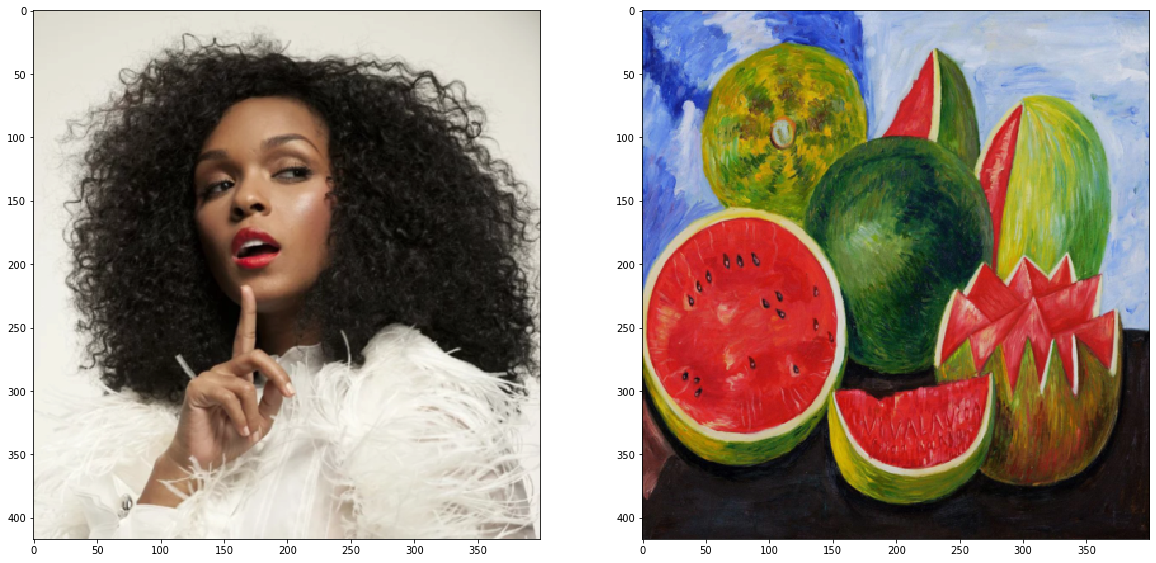

In [14]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))